# TCGA loader

This a workflow to aggregate the public Expression data from GDC

In [2]:
%cd ~/projs/tcga

/Users/fedor.grigoryev/projs/tcga


In order to process all the files simultaneously I am using the manifest file. In contains the `file_id`, `filename` as well as `md5` for checksums.

In [3]:
import requests
import re
from tqdm.notebook import tqdm
import time

def get_ids(manifest):
    try:
        with open(manifest, 'r') as input_:
            ids = [i.strip('\n').split('\t')[0] for i in input_.readlines()[1:]]
        no_of_samples = len(ids)
        return ids
        
    except Exception as ex:
        print(Exception)
        return None
        
manifest = '/Users/fedor.grigoryev/projs/tcga/gdc_manifest.2024-03-09.txt'
ids = get_ids(manifest)
len(ids)

24621

In [4]:
! head $manifest -3

==> /Users/fedor.grigoryev/projs/tcga/gdc_manifest.2024-03-09.txt <==
id	filename	md5	size	state
0d140db1-dc0d-431d-b389-846d05bbb827	d0ee5ff7-a49a-4633-93a6-40c9e29fb0b7.rna_seq.augmented_star_gene_counts.tsv	26025025d0192577ed275c5b45044abc	4243387	released
800ca72f-4bd7-46d7-904b-bcda2fa3500c	c58a5583-7b04-4b67-9372-e161e18d7de1.rna_seq.augmented_star_gene_counts.tsv	b5dc20e532aea0ccd78a17051879c228	4256989	released
958813f4-8036-42f7-856d-7a69c4175adc	269c35f0-a4f7-4e30-a69f-f1f3b7b5dace.rna_seq.augmented_star_gene_counts.tsv	0035fb5b56a204c5c0606b98b277344b	4237719	released
c7646bc5-436b-4ad5-b5ae-894b2e843cda	158ab1d9-8925-4a05-95da-b2e0ca297474.rna_seq.augmented_star_gene_counts.tsv	1769f7a4f42471f1f9a8977bae600208	4246730	released
90e074a0-ca6d-4031-aa26-f79e5c662ba7	9c2ed2bb-8ee1-441e-9f3b-ffbb4def2673.rna_seq.augmented_star_gene_counts.tsv	7d8a6169736e3b7b3267fb439690ad40	4244631	released
ac7c3a38-5d88-488e-86f7-1c72a26fe5ef	11ed8e05-8f30-460a-b502-01ae09504315.rna_seq.augmen

## Response parsing

Example response to infer the backbone for parsing:

In [5]:
file_id = '0d140db1-dc0d-431d-b389-846d05bbb827'
data_endpt = "https://api.gdc.cancer.gov/data/{}".format(file_id)
response = requests.get(data_endpt, headers = {"Content-Type": "application/json"}) 

In [7]:
response.__dict__.keys()

# full response content
# response.__dict__

dict_keys(['_content', '_content_consumed', '_next', 'status_code', 'headers', 'raw', 'url', 'encoding', 'history', 'reason', 'cookies', 'elapsed', 'request', 'connection'])

In [8]:
response.headers['Content-Disposition']

'attachment; filename=d0ee5ff7-a49a-4633-93a6-40c9e29fb0b7.rna_seq.augmented_star_gene_counts.tsv'

## Smallscale test load

Here I run the smallscale load on a small manifest file

In [5]:
manifest_short = '/Users/fedor.grigoryev/projs/tcga/gdc_manifest.2024-03-09_short.txt'
ids_short = get_ids(manifest_short)
len(ids_short)

9

In [7]:
import requests
import re
from tqdm.notebook import tqdm
import time

base_dir = '/Users/fedor.grigoryev/projs/tcga/downloads_test'

for file_id in tqdm(ids_short):
    data_endpt = "https://api.gdc.cancer.gov/data/{}".format(file_id)
    
    response = requests.get(data_endpt, headers = {"Content-Type": "application/json"})
    
    # The file name can be found in the header within the Content-Disposition key.
    response_head_cd = response.headers["Content-Disposition"]
    
    file_name = '/'.join((base_dir, re.findall("filename=(.+)", response_head_cd)[0]))
    
    with open(file_name, "wb") as output_file:
        output_file.write(response.content)

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
! rm /Users/fedor.grigoryev/projs/tcga/downloads_test/*

## Paralellisation

In [16]:
import os

num_cpu_cores = os.cpu_count()

if num_cpu_cores is not None:
    print("Number of CPU cores:", num_cpu_cores)
else:
    print("Number of CPU cores could not be determined.")

Number of CPU cores: 10


Utilising `ThreadPoolExecutor` for a speedup

In [10]:
import requests
import re
from tqdm.notebook import tqdm
import time
from concurrent.futures import ThreadPoolExecutor
import os

def download_file(file_id, base_dir):
    data_endpt = "https://api.gdc.cancer.gov/data/{}".format(file_id)
    
    response = requests.get(data_endpt, headers = {"Content-Type": "application/json"})
    
    response_head_cd = response.headers["Content-Disposition"]
    
    file_name = '/'.join((base_dir, re.findall("filename=(.+)", response_head_cd)[0]))
    
    if os.path.exists(file_name):
        return
    
    with open(file_name, "wb") as output_file:
        output_file.write(response.content)

### Smallscale concurrent load 

In [11]:
base_dir = '/Users/fedor.grigoryev/projs/tcga/downloads_test'

executor = ThreadPoolExecutor(max_workers=6)

futures = []
for file_id in tqdm(ids_short):
    future = executor.submit(download_file, file_id, base_dir)
    futures.append(future)

for future in tqdm(futures, desc="Downloading files"):
    future.result()

executor.shutdown()

  0%|          | 0/9 [00:00<?, ?it/s]

In [14]:
! ls -lh $base_dir | head -3

total 74640
-rw-r--r--  1 fedor.grigoryev  staff   4.0M May  3 11:19 01661d94-fc16-4456-95cf-a5fa4e1e196c.rna_seq.augmented_star_gene_counts.tsv
-rw-r--r--  1 fedor.grigoryev  staff   4.0M May  3 11:19 0d6fbefe-4e21-4762-a476-9c899d4a94b7.rna_seq.augmented_star_gene_counts.tsv


### Fullscale TCGA load

Paralellised for the sake of time

In [93]:
base_dir = '/Users/fedor.grigoryev/projs/tcga/downloads'

executor = ThreadPoolExecutor(max_workers=8)

futures = []
for file_id in tqdm(ids):
    future = executor.submit(download_file, file_id, base_dir)
    futures.append(future)

for future in tqdm(futures, desc="Downloading files"):
    future.result()

executor.shutdown()

In [26]:
downloaded_files = ! ls /Users/fedor.grigoryev/projs/tcga/downloads
manifest_lines = ! wc -l $manifest

assert int(str(manifest_lines).split()[1]) - 1 == len(downloaded_files)
assert len(ids) == len(downloaded_files)

## Checking checksums

In [20]:
manifest_df = pd.read_csv(manifest, sep='\t')
manifest_df.head()

,id,filename,md5,size,state
0,0d140db1-dc0d-431d-b389-846d05bbb827,d0ee5ff7-a49a-4633-93a6-40c9e29fb0b7.rna_seq.a...,26025025d0192577ed275c5b45044abc,4243387,released
1,800ca72f-4bd7-46d7-904b-bcda2fa3500c,c58a5583-7b04-4b67-9372-e161e18d7de1.rna_seq.a...,b5dc20e532aea0ccd78a17051879c228,4256989,released
2,958813f4-8036-42f7-856d-7a69c4175adc,269c35f0-a4f7-4e30-a69f-f1f3b7b5dace.rna_seq.a...,0035fb5b56a204c5c0606b98b277344b,4237719,released
3,c7646bc5-436b-4ad5-b5ae-894b2e843cda,158ab1d9-8925-4a05-95da-b2e0ca297474.rna_seq.a...,1769f7a4f42471f1f9a8977bae600208,4246730,released
4,90e074a0-ca6d-4031-aa26-f79e5c662ba7,9c2ed2bb-8ee1-441e-9f3b-ffbb4def2673.rna_seq.a...,7d8a6169736e3b7b3267fb439690ad40,4244631,released


In [31]:
filename2checksum = manifest_df.set_index('filename')['md5'].to_dict()

In [15]:
import hashlib

def calculate_md5(file_path):
    """
    Calculate the MD5 checksum of a file.
    
    Args:
        file_path (str): The path to the file.
    
    Returns:
        str: The MD5 checksum of the file.
    """
    with open(file_path, "rb") as file:
        md5_hash = hashlib.md5()
        
        # Read the file in chunks to handle large files
        for chunk in iter(lambda: file.read(4096), b""):
            md5_hash.update(chunk)
    
    # Get the hexadecimal representation of the MD5 hash
    md5_checksum = md5_hash.hexdigest()
    
    return md5_checksum

In [34]:
import os
from tqdm.notebook import tqdm

base_dir = '/Users/fedor.grigoryev/projs/tcga/downloads'

filenames = os.listdir(base_dir)

checksum_res = {}

def calculate_and_check_md5(filename):
    file_path = os.path.join(base_dir, filename)
    checksum = calculate_md5(file_path)
    expected_checksum = filename2checksum.get(filename)
    checksum_res[filename] = checksum == expected_checksum

executor = ThreadPoolExecutor(max_workers=8)

futures = []
for filename in filenames:
    future = executor.submit(calculate_and_check_md5, filename)
    futures.append(future)

for future in tqdm(futures, total=len(filenames), desc="Calculating checksums"):
    future.result()

executor.shutdown()

Calculating checksums:   0%|          | 0/24621 [00:00<?, ?it/s]

In [35]:
checksums = pd.Series(checksum_res)
checksums.value_counts()

True    24621
Name: count, dtype: int64

All right!

# TCGA aggregation

Now that I've loaded the individual sample files, they have to be processed and aggregated into the meaningful cohort-level representations

## Cohort structuring

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

Loaded clinical and biospecimen metadata that is yet to be matched to our expression files:

In [18]:
! ls data/

biospecimen.cohort.2024-03-09 cohorts
clinical.cohort.2024-03-09


GDC provides a `files202X-XX-XX.json` file that can be used to retrieve the `case_id` for a `file_id` therefore matching the expression data to its original patient and its clinical annotation. However this is not enough, because we still need a sample level annotation for example to discriminate Tumor vs Normal samples

In [21]:
id2filename = manifest_df.set_index('id')['filename'].to_dict()
filename2id = manifest_df.set_index('filename')['id'].to_dict()

In [29]:
clin_dir = 'data/clinical.cohort.2024-03-09'

clin = pd.read_csv(os.path.join(clin_dir, 'clinical.tsv'), sep='\t')

In [24]:
# Example of a file data entry
file_data = {
  "data_format": "TSV", 
  "cases": [
    {
      "case_id": "408cb583-6dc3-4698-8bd2-e284042bd5ef", 
      "project": {
        "project_id": "TCGA-BRCA"
      }
    }
  ], 
  "access": "open", 
  "file_name": "d0ee5ff7-a49a-4633-93a6-40c9e29fb0b7.rna_seq.augmented_star_gene_counts.tsv", 
  "file_id": "0d140db1-dc0d-431d-b389-846d05bbb827", 
  "data_type": "Gene Expression Quantification", 
  "data_category": "Transcriptome Profiling", 
  "experimental_strategy": "RNA-Seq", 
  "file_size": 4243387
}

In [25]:
pwd

'/Users/fedor.grigoryev/projs/tcga'

In [26]:
import json

with open('files.2024-03-16.json') as annots_json:
    annots = json.load(annots_json)

In [27]:
files = []
for annot in tqdm(annots):
    file_id = annot['file_id']
    file_name = annot['file_name']
    for case in annot['cases']:
        case_id = case['case_id']
        proj_id = case['project']['project_id']
        files.append([file_id, file_name, case_id, proj_id])

  0%|          | 0/24621 [00:00<?, ?it/s]

In [28]:
files_df = pd.DataFrame(files, columns=['file_id', 'file_name', 'case_id', 'proj_id']).set_index('file_name', drop=True)
files_df.head()

,file_id,case_id,proj_id
file_name,,,
d0ee5ff7-a49a-4633-93a6-40c9e29fb0b7.rna_seq.augmented_star_gene_counts.tsv,0d140db1-dc0d-431d-b389-846d05bbb827,408cb583-6dc3-4698-8bd2-e284042bd5ef,TCGA-BRCA
c58a5583-7b04-4b67-9372-e161e18d7de1.rna_seq.augmented_star_gene_counts.tsv,800ca72f-4bd7-46d7-904b-bcda2fa3500c,ff0f875f-113a-4c0f-8c0a-4259cd496e6d,TCGA-BRCA
269c35f0-a4f7-4e30-a69f-f1f3b7b5dace.rna_seq.augmented_star_gene_counts.tsv,958813f4-8036-42f7-856d-7a69c4175adc,408cb583-6dc3-4698-8bd2-e284042bd5ef,TCGA-BRCA
158ab1d9-8925-4a05-95da-b2e0ca297474.rna_seq.augmented_star_gene_counts.tsv,c7646bc5-436b-4ad5-b5ae-894b2e843cda,bef7b135-a727-45e8-850a-cc4cd56c49aa,TCGA-BRCA
9c2ed2bb-8ee1-441e-9f3b-ffbb4def2673.rna_seq.augmented_star_gene_counts.tsv,90e074a0-ca6d-4031-aa26-f79e5c662ba7,8332806e-f547-4aae-89af-6d5bec831fd2,TCGA-BRCA


Cohort discribution for downloaded files

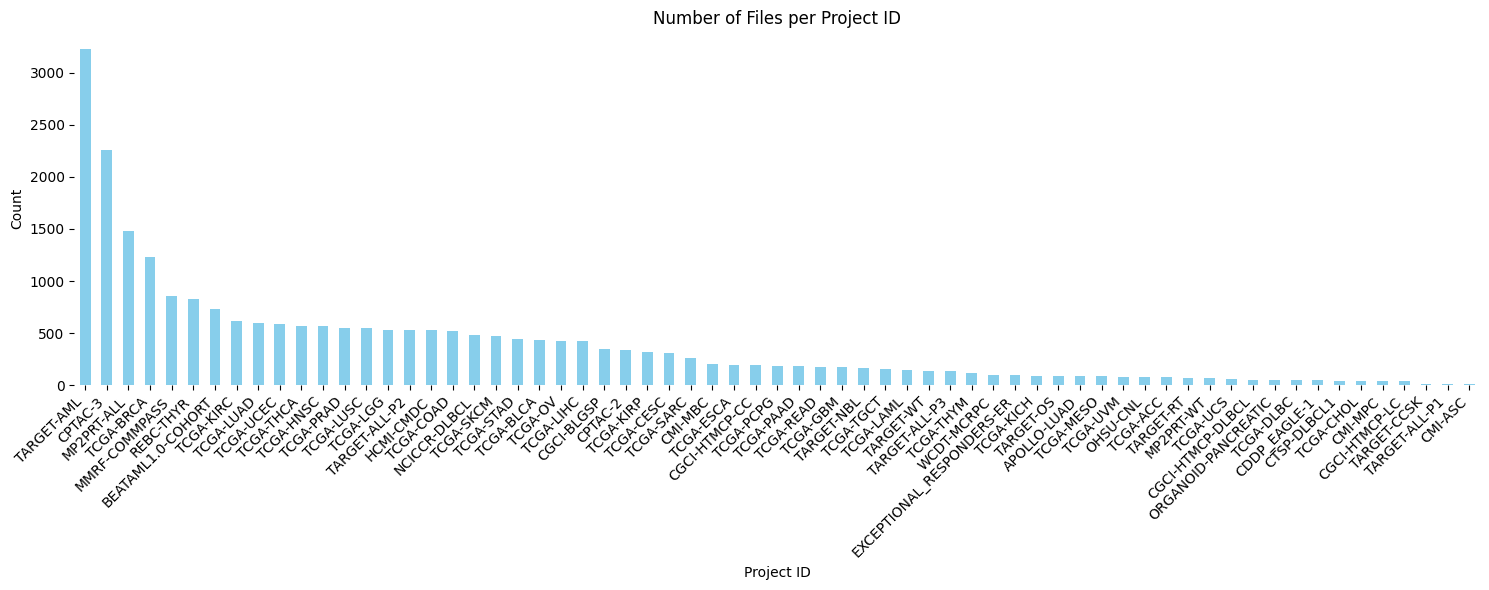

In [831]:
import matplotlib.pyplot as plt

proj_id_counts = files_df['proj_id'].value_counts()

plt.figure(figsize=(15, 6))  
proj_id_counts.plot(kind='bar', color='skyblue')  
plt.xlabel('Project ID')  
plt.ylabel('Count')
plt.title('Number of Files per Project ID') 
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.box(False)
plt.show()

In [180]:
files_case_ids = set(files_df['case_id'])
clin['case_id'].isin(files_case_ids).value_counts()

case_id
True     40524
False    26656
Name: count, dtype: int64

In [181]:
clin_case_ids = set(clin['case_id'])
files_df['case_id'].isin(clin_case_ids).value_counts()

case_id
True    24625
Name: count, dtype: int64

Some cases have a lot of associated files:

In [30]:
files_df['case_id'].value_counts()[:5]

case_id
98c21e0b-1373-4785-8edf-345c55fd370c    16
3a4afbe7-60d6-4a0d-8166-56a04ff127b0     8
842402de-519e-4588-ad49-19df18db899b     8
9ff6d022-6e23-4f44-a480-1b61929e6ee3     6
d617590c-0326-47c4-a327-103c2f82c999     5
Name: count, dtype: int64

Here I split every downloaded file into the several logical parts and store them by Cohort:

* QC related informatoin as `qc.tsv`, useful for downstream QC filtering
* raw counts (coding only) as `counts.tsv`, useful for DE analysis
* tpm data for downstream analysis

The subset of the total clinical annotation corresponding to the cohort is also stored as `clin_annotation.tsv` 

In [43]:
for proj_id, proj_data in tqdm(files_df.groupby('proj_id')):

    if proj_id == 'TARGET-NBL':
        continue 
    
    os.makedirs(f'data/cohorts/{proj_id}', exist_ok=True)

    qcs = []
    countss = []
    tpms = []
    
    for path in proj_data.index:
        pat = files_df.loc[path]['file_id']
        rna_data = pd.read_csv(f'downloads/{path}', sep='\t', comment='#')
        
        pc_rna = rna_data[rna_data['gene_type'] == 'protein_coding']
        pc_rna = pc_rna.groupby('gene_name').sum()

        qc = rna_data.set_index('gene_id').iloc[:4]['unstranded']
        qc.name = pat
        qc.index.name = 'file_id'
        
        counts = pc_rna['unstranded']
        counts.name = pat
        
        tpm = pc_rna['tpm_unstranded']
        tpm.name = pat
    
        qcs.append(qc)
        countss.append(counts)
        tpms.append(tpm)

    qc = pd.DataFrame(qcs)
    counts = pd.DataFrame(countss).T
    tpm = pd.DataFrame(tpms).T
    clin_annot = clin[clin['case_id'].isin(proj_data['case_id'])]

    qc['mapped'] = counts.sum(axis=0)

    qc.to_csv(f'data/cohorts/{proj_id}/qc.tsv', sep='\t')
    counts.to_csv(f'data/cohorts/{proj_id}/counts.tsv', sep='\t')
    tpm.to_csv(f'data/cohorts/{proj_id}/tpm.tsv', sep='\t')
    clin_annot.to_csv(f'data/cohorts/{proj_id}/clin_annotation.tsv', sep='\t')

  0%|          | 0/65 [00:00<?, ?it/s]

## File metadata retrieval from GDC API
To match the expression data (`file_id` based) with biospecimen and clinical data (`sample_id` and `case_id` based). In other words, for the loaded expression files we still need to extract the information for theil sample of origin. This can be done using the GDC 

For that we specify a backbone for the API query and modify its field corresponding to the values of `file_id`s

Extracted clinical and biospecimen information (indexed by `file_id`) is stored as `file_annotation.tsv`

In [3]:
%cd /Users/fedor.grigoryev/mycode

/Users/fedor.grigoryev/mycode


In [85]:
tcga_directory = '~/projs/tcga/data/cohorts'

expanded_directory = os.path.expanduser(tcga_directory)
cohorts = os.listdir(expanded_directory)
cohorts = [file for file in cohorts if not file.startswith('.')]

In [86]:
import json

payload_backbone_json = {
    "filters":{
        "op":"in",
        "content":{
            "field":"files.file_id",
            "value":[
                "0001801b-54b0-4551-8d7a-d66fb59429bf",
                "002c67f2-ff52-4246-9d65-a3f69df6789e"
            ]
        }
    },
    "format":"TSV",
    "fields":"file_id,file_name,cases.submitter_id,cases.case_id,data_category,data_type,cases.samples.tumor_descriptor,cases.samples.tissue_type,cases.samples.sample_type,cases.samples.submitter_id,cases.samples.sample_id,cases.samples.portions.analytes.aliquots.aliquot_id,cases.samples.portions.analytes.aliquots.submitter_id",
    "size":"10000"
} 

def update_payload_file_ids(json_backbone, ids):
    json_backbone['filters']['content']['value'] = ids
    
    with open(json_file, 'w') as f:
        json.dump(json_backbone, f, indent=4)
    return json_backbone

def rename_fnc(col):
    if 'cases' in col:
        if 'submitter_id' in col:
            return '.'.join(col.replace('.0', '').split('.')[-2:])
        else:
            return col.split('.')[-1]
    else:
        return col

unmatched_id_cohs = []

for coh in tqdm(cohorts):
    continue
    if coh != 'TARGET-NBL':
        print(f'Running for {coh}:')
        qc = pd.read_csv(f'{expanded_directory}/{coh}/qc.tsv', sep='\t', index_col=0)
        
        new_file_ids = list(qc.index)
        print(f'quering {len(new_file_ids)} indices:')
        payload_json = update_payload_file_ids(payload_backbone_json, new_file_ids)
        ! curl --request POST --header "Content-Type: application/json" --data @pl_files.txt 'https://api.gdc.cancer.gov/files' > response_files.tsv
    
        resp_df = pd.read_csv('response_files.tsv', sep='\t', index_col='id')
        cols = list(map(rename_fnc, resp_df.columns))
        resp_df.columns = cols
        print(f'received {resp_df.shape} values')
        
        if len(set(resp_df.index) ^ set(new_file_ids)) == 0:
            print('ids to response matched completely!\n')
        else:
            unmatched_id_cohs.append(coh)
            print('unmatched ids!\n')
        resp_df.to_csv(f'{expanded_directory}/{coh}/file_annotation.tsv', sep='\t')

  0%|          | 0/65 [00:00<?, ?it/s]

## QC

I'm going to use the avaliable QC annotation to mark the samples of poorer quality. The thresholding for that are going to be somewhat loose, but the final decision can be made on the base of the following QC plots:

In [37]:
def qc_plot(qc_df, ax=None):
    sns.barplot(qc_df['N_unmapped'] + qc_df['N_ambiguous'] + qc_df['N_multimapping'] + qc_df['N_noFeature'] + qc_df['mapped'], 
                color='lightgreen', label='mapped', ax=ax, errorbar=None)
    sns.barplot(qc_df['N_unmapped'] + qc_df['N_ambiguous'] + qc_df['N_multimapping'] + qc_df['N_noFeature'],
                color='darkblue', label='not annotated', ax=ax, errorbar=None)
    sns.barplot(qc_df['N_unmapped'] + qc_df['N_ambiguous'] + qc_df['N_multimapping'], 
                color='yellow', label='multimapping', ax=ax, errorbar=None)
    sns.barplot(qc_df['N_unmapped'] + qc_df['N_ambiguous'], 
                color='salmon', label='contamination', ax=ax, errorbar=None)
    sns.barplot(qc_df['N_unmapped'], 
                color='red', label='degradation', ax=ax, errorbar=None)


    ax.set_xlabel('Category')
    ax.set_ylabel('Value')
    ax.set_title('QC Plot')
    ax.tick_params(labelbottom=False)
    ax.legend()

In [44]:
proj_id = 'APOLLO-LUAD'
qc = pd.read_csv(f'data/cohorts/{proj_id}/qc.tsv', sep='\t', index_col=0)
qc

,N_unmapped,N_multimapping,N_noFeature,N_ambiguous,mapped
0a03b39d-ac42-4257-b7ff-a007bc642cb4,676976,6182901,21229880,3482515,17670180
e9381b02-b4ca-41fa-b21a-129345fae533,640250,5375117,6883052,2569603,9826544
79dea54b-587d-4442-b43d-0a32f6d1ff13,384285,2687614,11817881,3587663,16296409
b06317d0-3cdc-4868-a14c-ab65c698e399,1356023,9517591,26490923,5480400,28221402
d3398831-597b-4b11-ad25-61fa384213f3,631500,6500021,14239201,5910115,27632739
...,...,...,...,...,...
fdcf9032-f269-4dd5-ab79-e55892833dab,1023132,8762598,21830753,6057740,25740314
b4e66cd0-bec9-4196-a504-544e85740695,1171000,6205379,25898089,7299371,39443960
505837a5-3213-4a80-99f7-fe5064c205b3,922508,9085350,13068840,9575411,36670202
843a3d19-18af-433b-8ede-b556e4bb8c77,704681,6571843,19294905,4255029,22995857


  0%|          | 0/65 [00:00<?, ?it/s]

APOLLO-LUAD


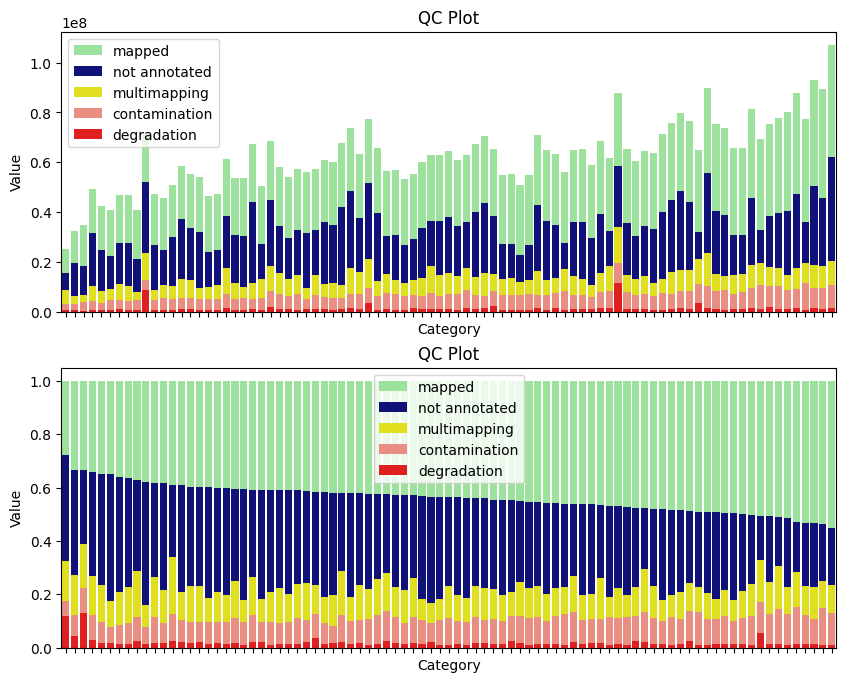

In [45]:
for proj_id, proj_data in tqdm(files_df.groupby('proj_id')):

    if proj_id == 'TARGET-NBL':
        continue 
        
    qc = pd.read_csv(f'data/cohorts/{proj_id}/qc.tsv', sep='\t', index_col=0)

    qc_norm = qc.div(qc.sum(axis=1), axis=0)

    print(proj_id)
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))

    size = min(500, qc.shape[0])
    
    qc_plot(qc.sort_values('mapped', ascending=True).iloc[:size], ax=ax[0])
    qc_plot(qc_norm.sort_values('mapped', ascending=True).iloc[:size], ax=ax[1])
    
    plt.show()

    break 

  0%|          | 0/65 [00:00<?, ?it/s]

APOLLO-LUAD


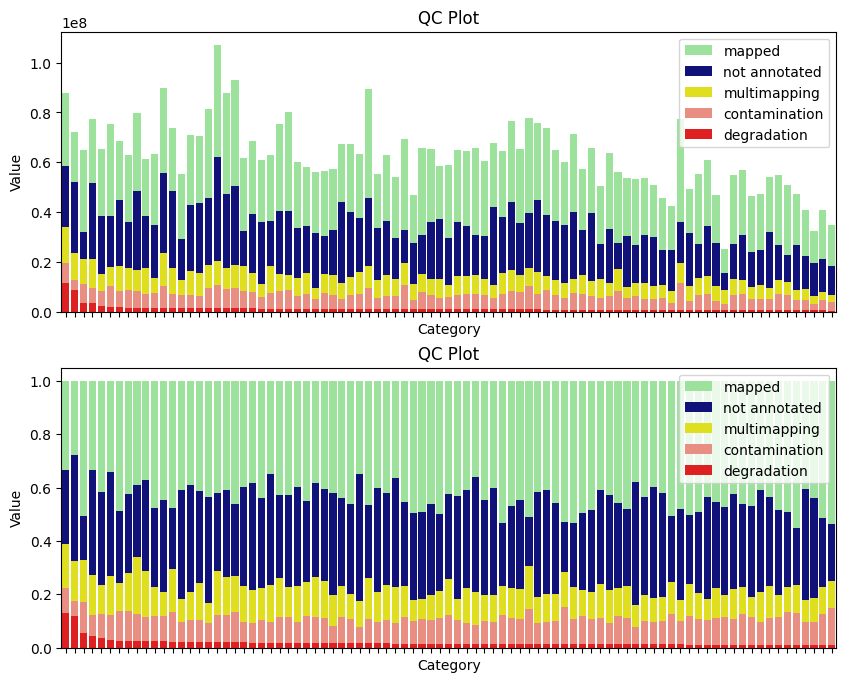

In [46]:
for proj_id, proj_data in tqdm(files_df.groupby('proj_id')):

    if proj_id == 'TARGET-NBL':
        continue 
        
    qc = pd.read_csv(f'data/cohorts/{proj_id}/qc.tsv', sep='\t', index_col=0)

    qc_norm = qc.div(qc.sum(axis=1), axis=0)

    print(proj_id)
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))

    size = min(500, qc.shape[0])
    
    qc_plot(qc.sort_values('N_unmapped', ascending=False).iloc[:size], ax=ax[0])
    qc_plot(qc_norm.sort_values('N_unmapped', ascending=False).iloc[:size], ax=ax[1])

    plt.show()
    break

## QC filtering

The QC tresholding procedure is based on the number of mapped reads as well as the relative fraction of unmapped reads and ambiguous

In [62]:
qc_cols = ['N_unmapped', 'N_multimapping', 'N_noFeature', 'N_ambiguous', 'mapped']

qc_fltr = dict()

for proj_id, proj_data in tqdm(files_df.groupby('proj_id')):
    if proj_id == 'TARGET-NBL':
        continue 
        
    qc = pd.read_csv(f'data/cohorts/{proj_id}/qc.tsv', sep='\t', index_col=0)[qc_cols]
    qc_norm = qc.div(qc.sum(axis=1), axis=0)

    filtered_out = (set(qc[qc['mapped'] < 1e7].index) | 
                    set(qc_norm[qc_norm['N_unmapped'] > .30].index) | 
                    set(qc_norm[qc_norm['N_ambiguous'] > .30].index))

    qc['qc_passed_flag'] =  ~qc.index.isin(filtered_out)
    qc.to_csv(f'data/cohorts/{proj_id}/qc.tsv', sep='\t')
    
    qc_fltr[proj_id] = [len(filtered_out), len(filtered_out) / qc.shape[0]]
    

  0%|          | 0/65 [00:00<?, ?it/s]

Statistics for identified outliers

In [63]:
qc_fltr = pd.DataFrame(qc_fltr.values(), columns=['N_fltrd', 'Frac_fltrd'], index=qc_fltr.keys())

In [64]:
qc_fltr.sum()

N_fltrd       632.000000
Frac_fltrd      2.713358
dtype: float64

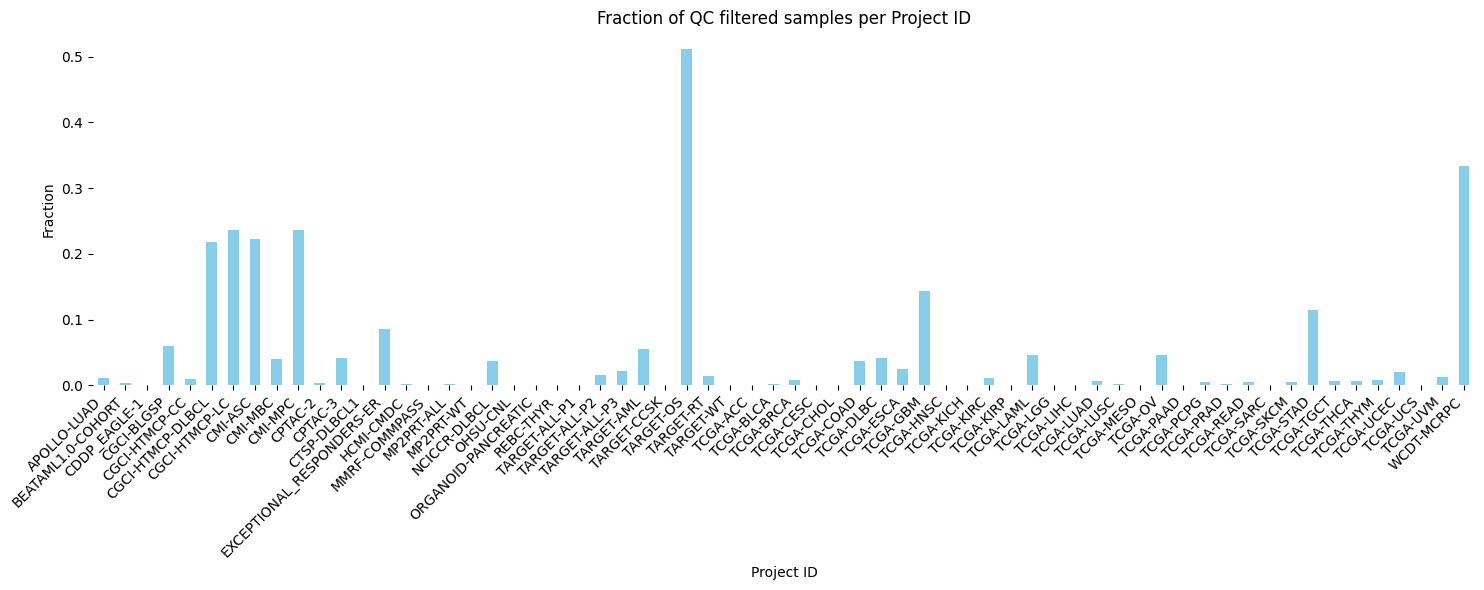

In [69]:


plt.figure(figsize=(15, 6))  
qc_fltr['Frac_fltrd'].plot(kind='bar', color='skyblue')    
plt.xlabel('Project ID')  
plt.ylabel('Fraction')
plt.title('Fraction of QC filtered samples per Project ID') 
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.box(False)
plt.show()

<Axes: >

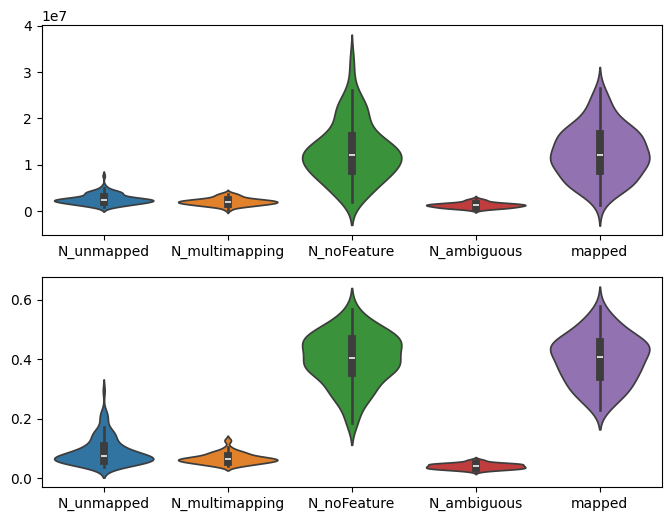

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(8 ,6))
sns.violinplot(qc.drop(columns=['qc_passed_flag']), ax=ax[0])
sns.violinplot(qc_norm, ax=ax[1])

Also here is an example of an easy outlier filtering based on Mahalanobis distance

In [58]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

np.random.seed(0)
num_rows = 100
num_columns = 5
data = np.random.randn(num_rows, num_columns)
df = pd.DataFrame(data, columns=[f"Feature_{i}" for i in range(num_columns)])

mean_vec = np.mean(df, axis=0)
cov_mat = np.cov(df.values.T)

diff = df - mean_vec
inv_cov = np.linalg.inv(cov_mat)
mahalanobis_sq = np.sum(np.dot(diff, inv_cov) * diff, axis=1)

alpha = 0.01  # Significance level
threshold = chi2.ppf(1 - alpha, df=num_columns)

outliers = df[mahalanobis_sq > threshold]

print("Outliers:")
print(outliers)

Outliers:
Empty DataFrame
Columns: [Feature_0, Feature_1, Feature_2, Feature_3, Feature_4]
Index: []


# TCGA analysis example

Example of analytics that could be done on aqcuired data

## Gene expression  profiling by diagnosis 

In [90]:
import os 

exps = []
cohs = os.listdir('data/cohorts')
for coh in cohs:
    print(coh)
    exp = pd.read_csv(f'data/cohorts/{coh}/tpm.tsv', sep='\t', index_col=0)
    qc = pd.read_csv(f'data/cohorts/{coh}/qc.tsv', sep='\t', index_col=0)
    break

TCGA-LUSC


In [91]:
alpha = 0.001  # Significance level
threshold = chi2.ppf(1 - alpha, df=num_columns)
threshold

20.515005652432873

Oultier identification

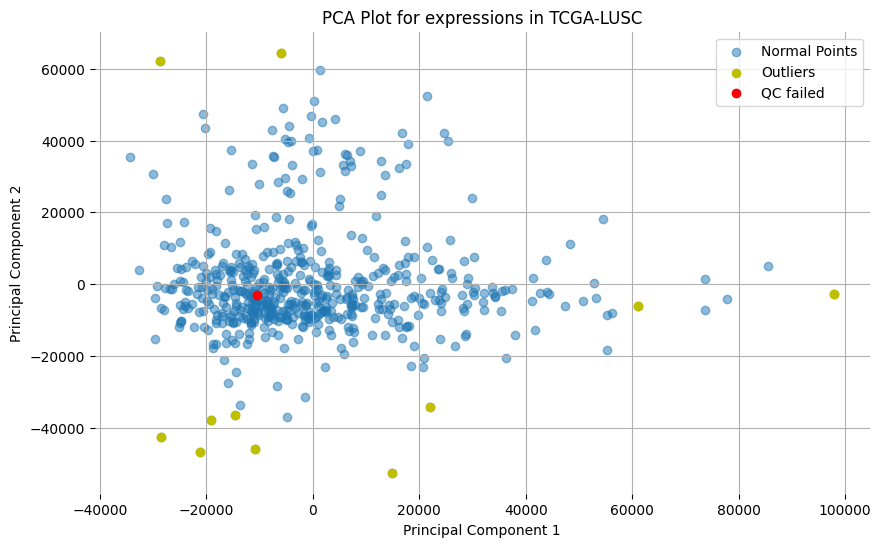

In [92]:
from scipy.stats import chi2
from sklearn.decomposition import PCA

df = exp.T

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df)

mean_vec = np.mean(pca_result, axis=0)
cov_mat = np.cov(pca_result.T)

diff = pca_result - mean_vec
inv_cov = np.linalg.inv(cov_mat)
mahalanobis_sq = np.sum(np.dot(diff, inv_cov) * diff, axis=1)

alpha = 0.001  # Significance level
threshold = chi2.ppf(1 - alpha, df=num_columns)

outliers_mask = mahalanobis_sq > threshold

qc_mask = exp.T.reset_index()['index'].map(qc['qc_passed_flag'])

pca_result = pca_result[:,:2]

plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], label="Normal Points", alpha=0.5)
plt.scatter(pca_result[outliers_mask][:, 0], pca_result[outliers_mask][:, 1], color='y', label="Outliers")
plt.scatter(pca_result[~qc_mask][:, 0], pca_result[~qc_mask][:, 1], color='r', label="QC failed")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Plot for expressions in TCGA-LUSC")
plt.legend()
plt.grid(True)
plt.box(False)
plt.show()

In [93]:
qc_index = qc[qc['qc_passed_flag']].index

Gene expression correlations with some known cancer driving genes

In [95]:
from scipy.stats import spearmanr

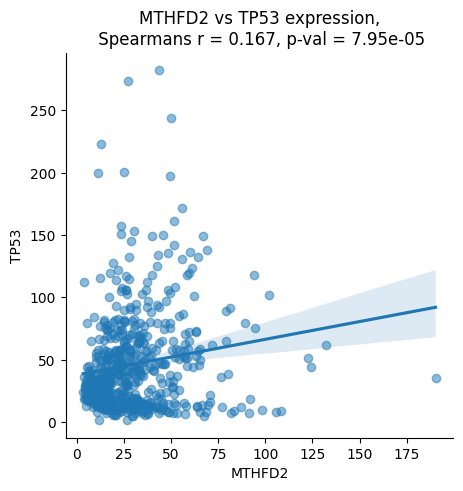

In [96]:
def corregplot(exp, goi, driver):
    r, p = spearmanr(exp.loc[goi], exp.loc[driver])
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.regplot(x=goi, y=driver, data=exp.T, scatter_kws={'alpha': .5})
    ax.set_title(f'{goi} vs {driver} expression,\n Spearmans r = {r:.3f}, p-val = {p:.2e}', fontsize=12, loc='center')
    sns.despine()

goi = 'MTHFD2' # gene of interest
driver = 'TP53'

corregplot(exp[qc_index], goi, driver)

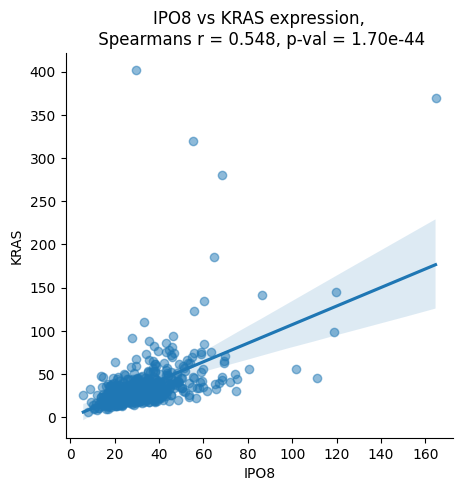

In [97]:
goi = 'IPO8' # gene of interest
driver = 'KRAS'

corregplot(exp[qc_index], goi, driver)

In [98]:
cancer_driver_genes_example = [
    'ABL1',
    'ALK',
    'BRAF',
    'BTK',
    'EGFR',
    'ESR1',
    'FLT3',
    'KIT',
    'MAP2K1',
    'MAP2K2',
    'PDGFRA',
    'SMO',
    'MET',
    'JAK1',
    'JAK2'
]


# TCGA exploration

Exploring TCGA clinical and sample metadata

In [99]:
file_id2case_id = files_df.set_index('file_id')['case_id'].to_dict()

In [100]:
! ls data/clinical.cohort.2024-03-09

clinical.tsv         family_history.tsv   pathology_detail.tsv
exposure.tsv         follow_up.tsv


In [101]:
pathology = pd.read_csv(os.path.join(clin_dir, 'pathology_detail.tsv'), sep='\t')
pathology.head()

,case_id,case_submitter_id,project_id,diagnosis_id,diagnosis_submitter_id,additional_pathology_findings,anaplasia_present,anaplasia_present_type,bone_marrow_malignant_cells,breslow_thickness,...,rhabdoid_percent,rhabdoid_present,sarcomatoid_percent,sarcomatoid_present,size_extraocular_nodule,transglottic_extension,tumor_largest_dimension_diameter,tumor_thickness,vascular_invasion_present,vascular_invasion_type
0,000ead0d-abf5-4606-be04-1ea31b999840,C3N-01179,CPTAC-3,cd5bc769-8b9d-4a1a-b6e0-fb489be6785e,C3N-01179-DIAG,'--,'--,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,4.0,'--,'--,'--
1,001ab32d-f924-4753-ad67-4366fb845ae6,BLGSP-71-30-00678,CGCI-BLGSP,c2d74eef-4bf5-45b2-9ce4-2e236a4b206c,BLGSP-71-30-00678_diagnosis,'--,'--,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--
2,001ab32d-f924-4753-ad67-4366fb845ae6,BLGSP-71-30-00678,CGCI-BLGSP,c2d74eef-4bf5-45b2-9ce4-2e236a4b206c,BLGSP-71-30-00678_diagnosis,'--,'--,'--,No,'--,...,'--,'--,'--,'--,'--,'--,10.0,'--,'--,'--
3,0024c94c-88ff-49d9-8dc4-bf77f832d85e,BLGSP-71-06-00137,CGCI-BLGSP,0e3c31ff-f17e-5a68-9398-936fbee8f391,BLGSP-71-06-00137_diagnosis,'--,'--,'--,Unknown,'--,...,'--,'--,'--,'--,'--,'--,2.0,'--,'--,'--
4,0024c94c-88ff-49d9-8dc4-bf77f832d85e,BLGSP-71-06-00137,CGCI-BLGSP,0e3c31ff-f17e-5a68-9398-936fbee8f391,BLGSP-71-06-00137_diagnosis,'--,'--,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--


In [102]:
pathology.columns

Index(['case_id', 'case_submitter_id', 'project_id', 'diagnosis_id',
       'diagnosis_submitter_id', 'additional_pathology_findings',
       'anaplasia_present', 'anaplasia_present_type',
       'bone_marrow_malignant_cells', 'breslow_thickness',
       'circumferential_resection_margin', 'columnar_mucosa_present',
       'consistent_pathology_review', 'dysplasia_degree', 'dysplasia_type',
       'greatest_tumor_dimension', 'gross_tumor_weight',
       'largest_extrapelvic_peritoneal_focus', 'lymph_node_involved_site',
       'lymph_node_involvement', 'lymph_nodes_positive', 'lymph_nodes_tested',
       'lymphatic_invasion_present', 'margin_status', 'metaplasia_present',
       'morphologic_architectural_pattern', 'necrosis_percent',
       'necrosis_present', 'non_nodal_regional_disease',
       'non_nodal_tumor_deposits', 'number_proliferating_cells',
       'pathology_detail_id', 'pathology_detail_submitter_id',
       'percent_tumor_invasion', 'perineural_invasion_present',
      

In [103]:
! ls data/biospecimen.cohort.2024-03-09

aliquot.tsv analyte.tsv portion.tsv sample.tsv  slide.tsv


In [104]:
biospecimen_dir = 'data/biospecimen.cohort.2024-03-09'
sample = pd.read_csv(os.path.join(biospecimen_dir, 'sample.tsv'), sep='\t')
sample.head()

,project_id,case_id,case_submitter_id,sample_id,sample_submitter_id,biospecimen_anatomic_site,biospecimen_laterality,catalog_reference,composition,current_weight,...,shortest_dimension,specimen_type,state,time_between_clamping_and_freezing,time_between_excision_and_freezing,tissue_collection_type,tissue_type,tumor_code,tumor_code_id,tumor_descriptor
0,FM-AD,7c9fb8b9-f319-4780-8575-22380156e4cc,AD2341,5e5aac26-6844-40d6-a0a6-c9ee12fe9b79,AD2341_sample,'--,'--,'--,'--,'--,...,'--,Unknown,released,'--,'--,'--,Tumor,'--,'--,Primary
1,FM-AD,fa364d7b-a0c6-4a63-abe1-bff0babb040f,AD2766,483f8641-8f1a-47a6-a3e6-a67260ef83d6,AD2766_sample,'--,'--,'--,'--,'--,...,'--,Unknown,released,'--,'--,'--,Tumor,'--,'--,Metastatic
2,FM-AD,99314553-1341-43c1-bebd-de9d5b0d22d7,AD11274,9e0c399d-3029-4861-80d1-e5868f3eb66f,AD11274_sample,'--,'--,'--,'--,'--,...,'--,Unknown,released,'--,'--,'--,Tumor,'--,'--,Metastatic
3,FM-AD,2967907a-d590-40c3-9667-10ef5e90c621,AD10199,a5b554b0-407e-49e3-9693-a623727efcfd,AD10199_sample,'--,'--,'--,'--,'--,...,'--,Unknown,released,'--,'--,'--,Tumor,'--,'--,Unknown
4,FM-AD,ed012ac6-1475-444d-96c1-1d4943696e08,AD6924,dd9ff28e-e3f9-4407-a413-676c7b89f294,AD6924_sample,'--,'--,'--,'--,'--,...,'--,Unknown,released,'--,'--,'--,Tumor,'--,'--,Primary
